# Lines of Sight Analysis
For a few sample points in our AR, look at the profile along the LOS as a function of time

In [309]:
import os
import sys

import numpy as np
import h5py
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from astropy.coordinates import SkyCoord
from sunpy.map import Map
from sunpy.coordinates.frames import HeliographicStonyhurst
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels
from synthesizAR.util import heeq_to_hcc_coord

%matplotlib inline

First, get the base field.

In [2]:
base_field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

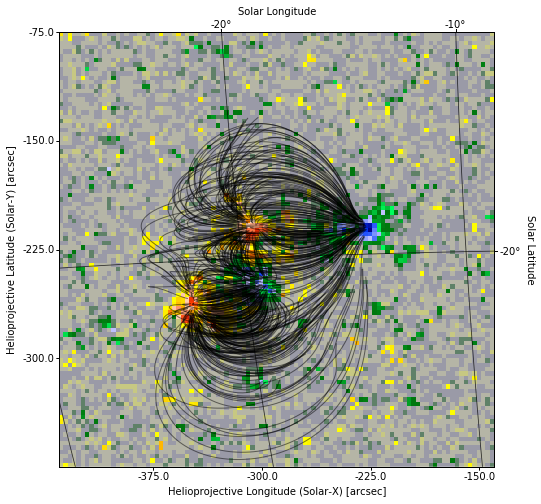

In [9]:
fig = plt.figure(figsize= (8, 8))
ax = fig.gca(projection=base_field.magnetogram)
# Plot map
norm = matplotlib.colors.Normalize(vmin=-1.5e3, vmax=1.5e3)
base_field.magnetogram.plot(axes=ax, title=False, cmap='hmimag', norm=norm)
# Grid
ax.grid(alpha=0.)
base_field.magnetogram.draw_grid(axes=ax, grid_spacing=10*u.deg, alpha=0.75, color='k')
# Lines
for line in [loop.coordinates for loop in base_field.loops[::10]]:
    # Convert to proper coordinates
    coord = (heeq_to_hcc_coord(line[:, 0], line[:, 1], line[:, 2],
                               base_field.magnetogram.observer_coordinate)
             .transform_to(base_field.magnetogram.coordinate_frame))
    # Plot line
    ax.plot_coord(coord, '-', color='k', lw=1, alpha=0.5)

In [10]:
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/nei/SDO_AIA/171/map_t001000.fits')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy-0.9.dev9659-py3.6-linux-x86_64.egg/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


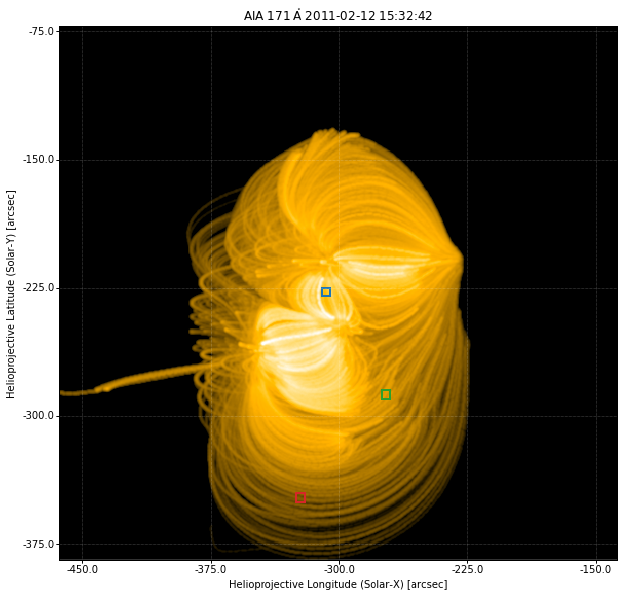

In [405]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=m)
m.plot(axes=ax,
       #norm=ImageNormalize(vmin=0,vmax=1e3,stretch=SqrtStretch())
       norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e-3,vmax=1e3)
      )
# Inner Core
width,height = 5*u.arcsec,5*u.arcsec
left_ic = SkyCoord(Tx=-310*u.arcsec,Ty=-230*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_ic = SkyCoord(Tx=left_ic.Tx+width,Ty=left_ic.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_ic, width, height, axes=ax, lw=2, color='C0')
# Outer Core
left_oc = SkyCoord(Tx=-275*u.arcsec,Ty=-290*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_oc = SkyCoord(Tx=left_oc.Tx+width,Ty=left_oc.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_oc, width, height, axes=ax, lw=2, color='C2')
# Periphery
left_p = SkyCoord(Tx=-325*u.arcsec,Ty=-350*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_p = SkyCoord(Tx=left_p.Tx+width,Ty=left_p.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_p, width, height, axes=ax, lw=2, color='C3')

## Select Loops

In [335]:
left_ic_heeq = left_ic.transform_to('heliographic_stonyhurst').cartesian
right_ic_heeq = right_ic.transform_to('heliographic_stonyhurst').cartesian

In [344]:
loop_coords_hpc = []
for loop in base_field.loops:
    tmp = heeq_to_hcc_coord(*loop.coordinates.T, base_field.magnetogram.observer_coordinate)
    loop_coords_hpc.append(tmp.transform_to(base_field.magnetogram.coordinate_frame))

In [345]:
### Inner Core ###
loops_ic = []
x_left = left_ic.Tx.value#_heeq.y.to(u.cm).value
x_right = right_ic.Tx.value#_heeq.to(u.cm).value
y_left = left_ic.Ty.value#_heeq.z.to(u.cm).value
y_right = right_ic.Ty.value#_heeq.z.to(u.cm).value
for i,loop_hpc in enumerate(loop_coords_hpc):
    x,y = loop_hpc.Tx.value, loop_hpc.Ty.value
    ix, = np.where(np.logical_and(x >= x_left, x <= x_right))
    if ix.shape[0] == 0:
        continue
    iy, = np.where(np.logical_and(y >= y_left, y <= y_right))
    if iy.shape[0] == 0:
        continue
    intersect = np.intersect1d(ix,iy,assume_unique=True)
    if intersect.shape[0] == 0:
        continue
    loops_ic.append(base_field.loops[i])
### Outer Core ###
loops_oc = []
x_left = left_oc.Tx.value
x_right = right_oc.Tx.value
y_left = left_oc.Ty.value
y_right = right_oc.Ty.value
for i,loop_hpc in enumerate(loop_coords_hpc):
    x,y = loop_hpc.Tx.value, loop_hpc.Ty.value
    ix, = np.where(np.logical_and(x >= x_left, x <= x_right))
    if ix.shape[0] == 0:
        continue
    iy, = np.where(np.logical_and(y >= y_left, y <= y_right))
    if iy.shape[0] == 0:
        continue
    intersect = np.intersect1d(ix,iy,assume_unique=True)
    if intersect.shape[0] == 0:
        continue
    loops_oc.append(base_field.loops[i])
### Periphery ###
loops_p = []
x_left = left_p.Tx.value
x_right = right_p.Tx.value
y_left = left_p.Ty.value
y_right = right_p.Ty.value
for i,loop_hpc in enumerate(loop_coords_hpc):
    x,y = loop_hpc.Tx.value, loop_hpc.Ty.value
    ix, = np.where(np.logical_and(x >= x_left, x <= x_right))
    if ix.shape[0] == 0:
        continue
    iy, = np.where(np.logical_and(y >= y_left, y <= y_right))
    if iy.shape[0] == 0:
        continue
    intersect = np.intersect1d(ix,iy,assume_unique=True)
    if intersect.shape[0] == 0:
        continue
    loops_p.append(base_field.loops[i])

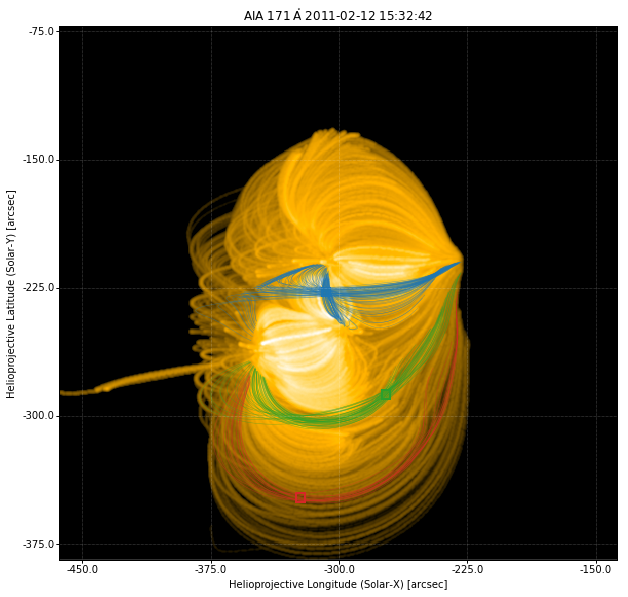

In [346]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=m)
m.plot(axes=ax,
       #norm=ImageNormalize(vmin=0,vmax=1e3,stretch=SqrtStretch())
       norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e-3,vmax=1e3)
      )
# Inner Core
width,height = 5*u.arcsec,5*u.arcsec
left_ic = SkyCoord(Tx=-310*u.arcsec,Ty=-230*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_ic = SkyCoord(Tx=left_ic.Tx+width,Ty=left_ic.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_ic, width, height, axes=ax, lw=2, color='C0')
for l in loops_ic:
    # Convert to proper coordinates
    coord = (heeq_to_hcc_coord(l.coordinates[:, 0], l.coordinates[:, 1], l.coordinates[:, 2],
                               base_field.magnetogram.observer_coordinate)
             .transform_to(base_field.magnetogram.coordinate_frame))
    # Plot line
    ax.plot_coord(coord, '-', color='C0', lw=0.5, alpha=0.5)
# Outer Core
left_oc = SkyCoord(Tx=-275*u.arcsec,Ty=-290*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_oc = SkyCoord(Tx=left_oc.Tx+width,Ty=left_oc.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_oc, width, height, axes=ax, lw=2, color='C2')
for l in loops_oc:
    # Convert to proper coordinates
    coord = (heeq_to_hcc_coord(l.coordinates[:, 0], l.coordinates[:, 1], l.coordinates[:, 2],
                               base_field.magnetogram.observer_coordinate)
             .transform_to(base_field.magnetogram.coordinate_frame))
    # Plot line
    ax.plot_coord(coord, '-', color='C2', lw=0.5, alpha=0.5)
# Periphery
left_p = SkyCoord(Tx=-325*u.arcsec,Ty=-350*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_p = SkyCoord(Tx=left_p.Tx+width,Ty=left_p.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_p, width, height, axes=ax, lw=2, color='C3')
for l in loops_p:
    # Convert to proper coordinates
    coord = (heeq_to_hcc_coord(l.coordinates[:, 0], l.coordinates[:, 1], l.coordinates[:, 2],
                               base_field.magnetogram.observer_coordinate)
             .transform_to(base_field.magnetogram.coordinate_frame))
    # Plot line
    ax.plot_coord(coord, '-', color='C3', lw=0.5, alpha=0.5)

Now, lets look at the temperature and density profiles in each spot for each heating model. 

### High Frequency Heating

In [349]:
hf_field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/field_checkpoint/')

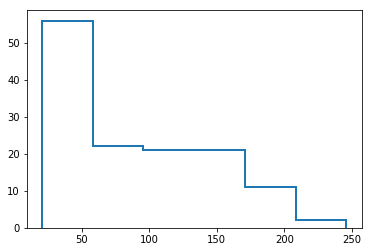

In [355]:
plt.hist([l.full_length.to(u.Mm).value for l in loops_ic],bins='fd',histtype='step',lw=2);

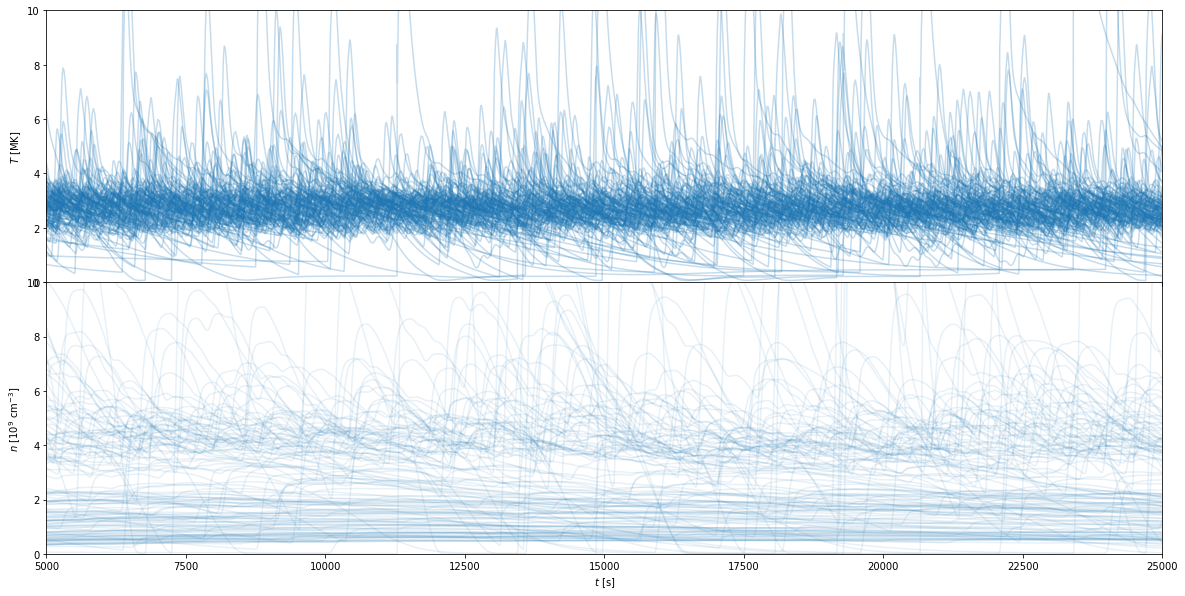

In [418]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_ic[:]:
    loop = hf_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.25)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.25)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,10)
axes[1].set_ylim(0,10)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

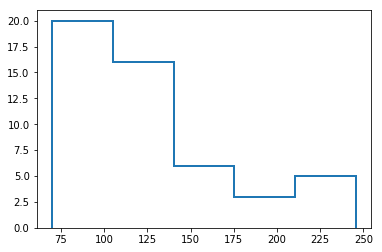

In [375]:
plt.hist([l.full_length.to(u.Mm).value for l in loops_oc],bins='fd',histtype='step',lw=2);

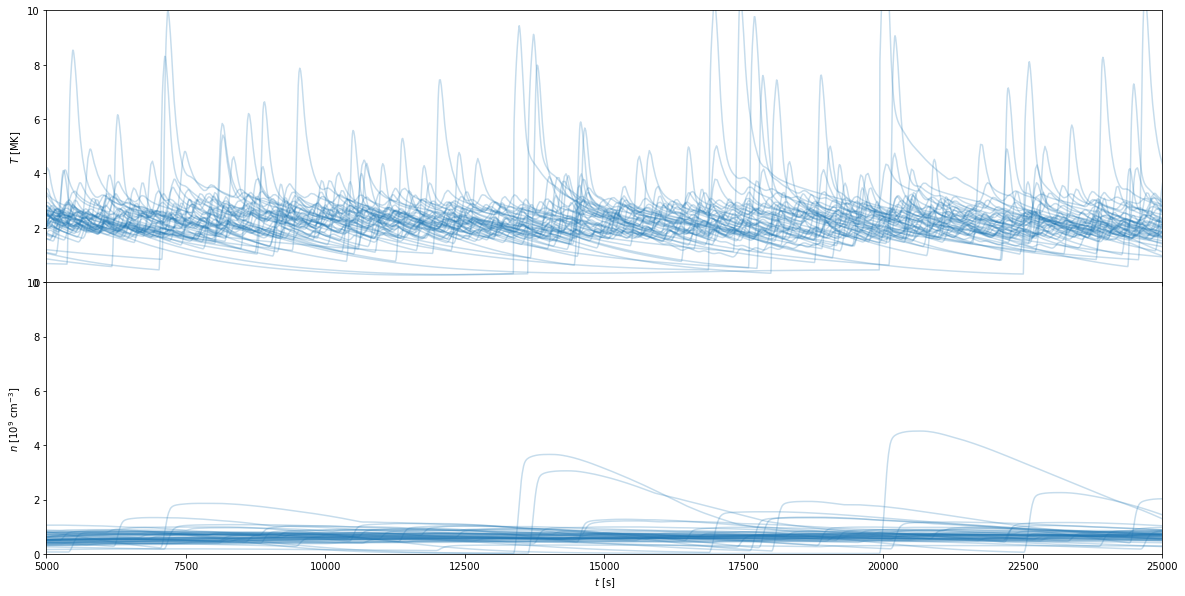

In [422]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_oc[:]:
    loop = hf_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.25)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.15)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.25)
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,10)
axes[1].set_ylim(0,10)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

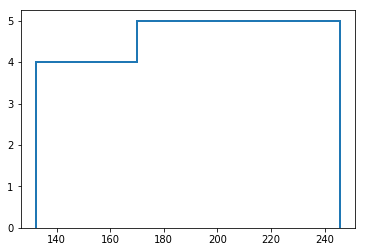

In [376]:
plt.hist([l.full_length.to(u.Mm).value for l in loops_p],bins='fd',histtype='step',lw=2);

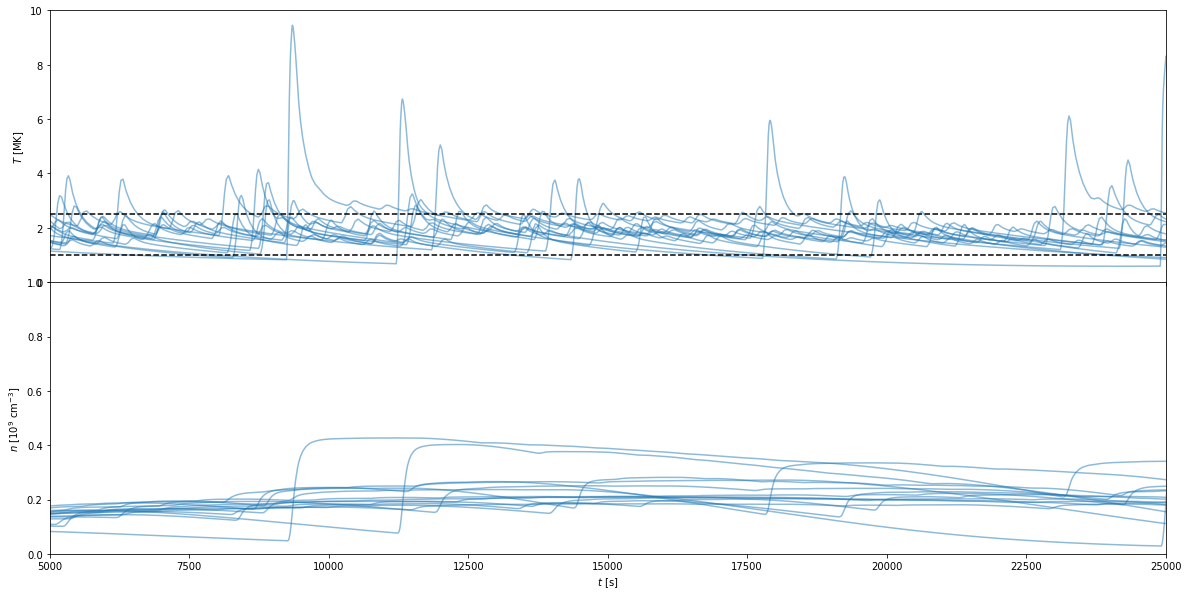

In [370]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_p[:]:
    loop = hf_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.5)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.5)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.5)
axes[0].axhline(y=1,ls='--',color='k')
axes[0].axhline(y=2.5,ls='--',color='k')
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,10)
axes[1].set_ylim(0,1)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

### Intermediate Frequency Heating

In [377]:
if_field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/field_checkpoint/')

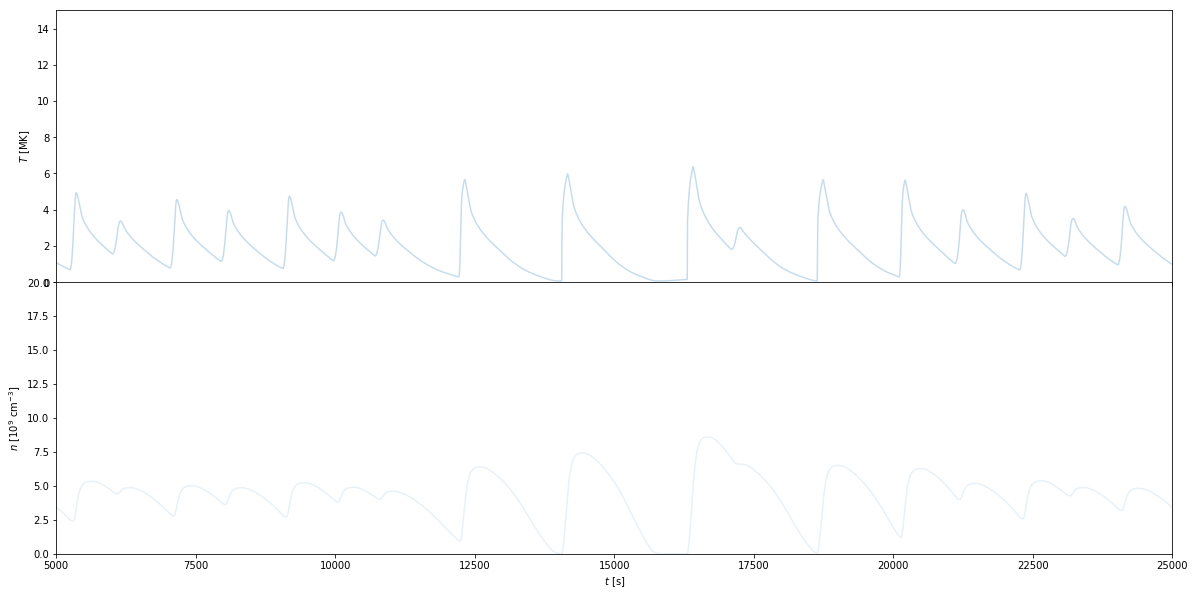

In [413]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_ic[5:6]:
    loop = if_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.25)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.25)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,15)
axes[1].set_ylim(0,20)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

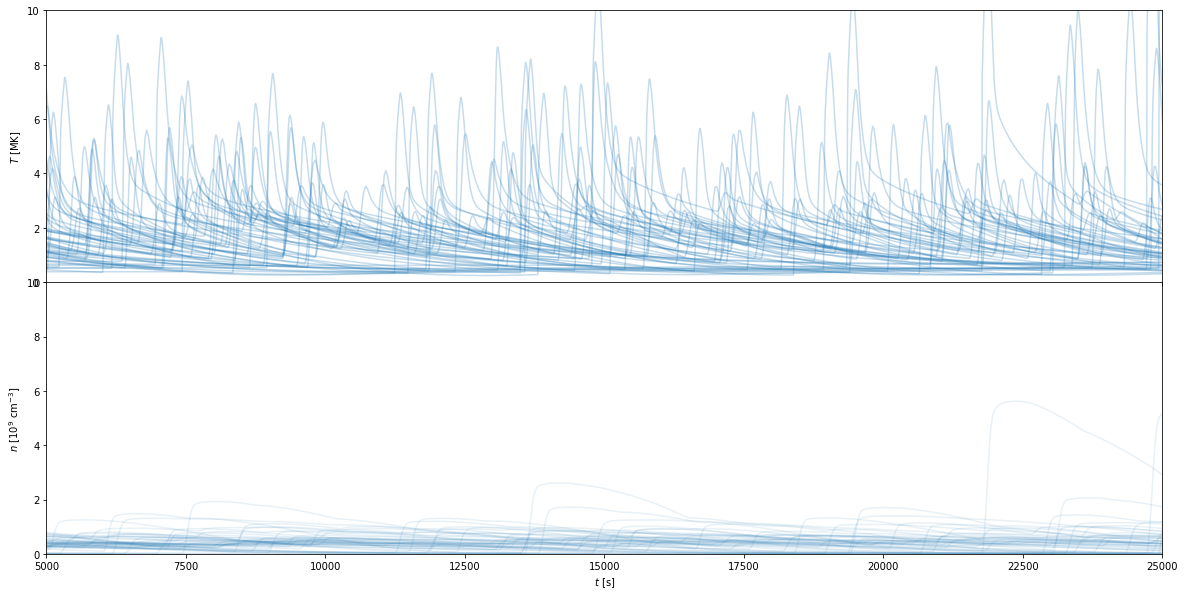

In [384]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_oc:
    loop = if_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.25)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.25)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,10)
axes[1].set_ylim(0,10)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

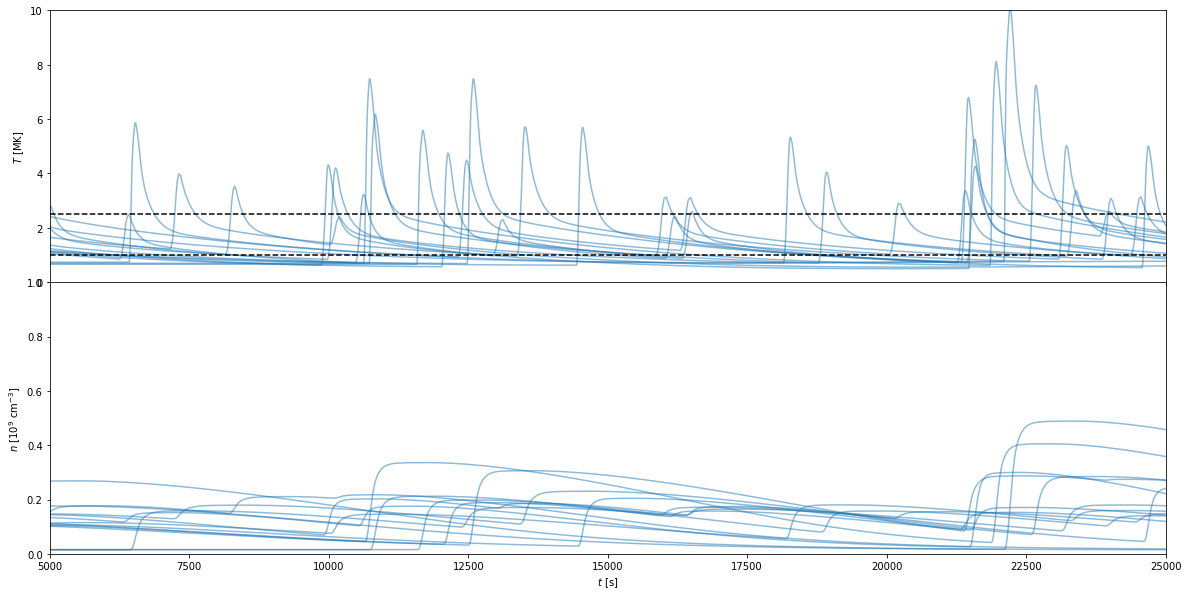

In [385]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_p[:]:
    loop = if_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.5)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.5)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.5)
axes[0].axhline(y=1,ls='--',color='k')
axes[0].axhline(y=2.5,ls='--',color='k')
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,10)
axes[1].set_ylim(0,1)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

### Low Frequency Heating

In [423]:
lf_field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/field_checkpoint/')

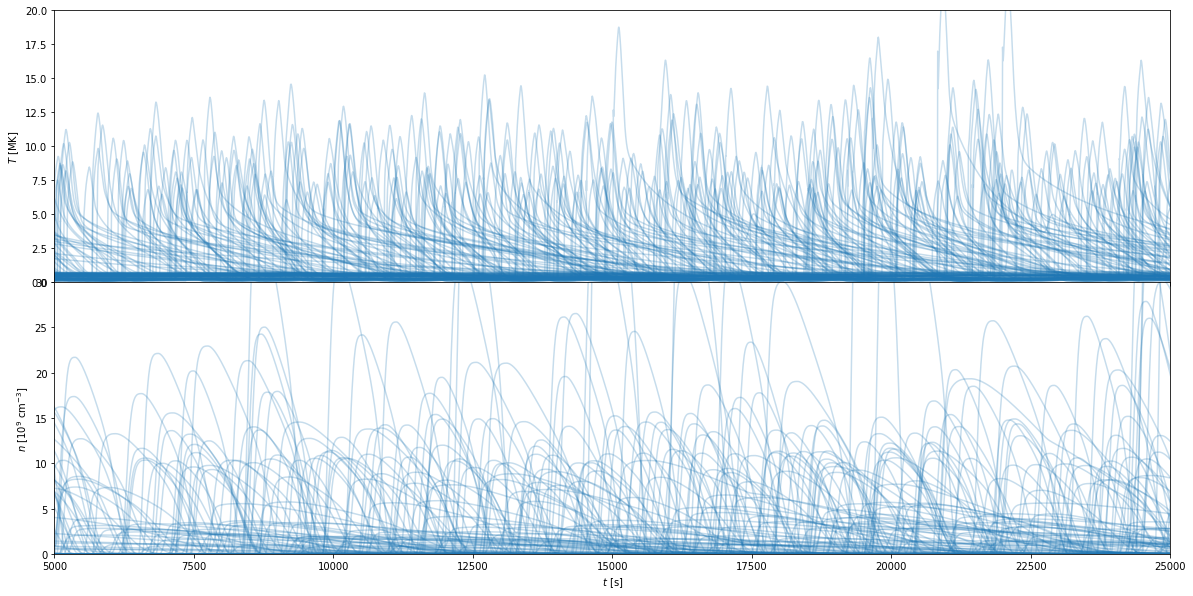

In [424]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_ic[:]:
    loop = lf_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.25)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.25)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.25)
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,20)
axes[1].set_ylim(0,30)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

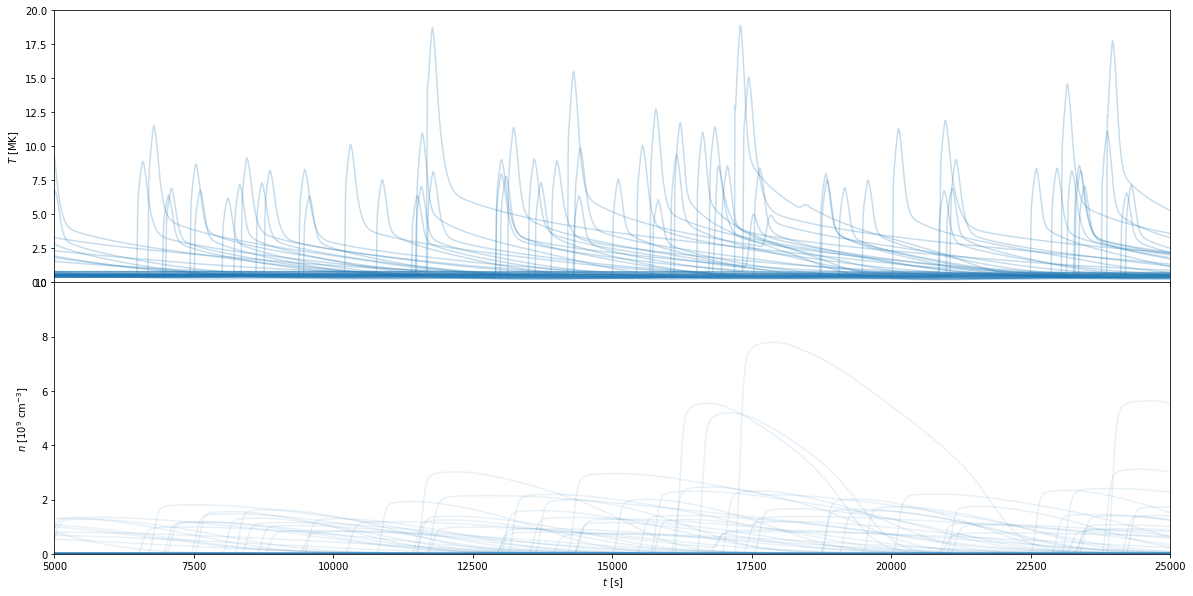

In [393]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_oc:
    loop = lf_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.25)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.25)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,20)
axes[1].set_ylim(0,10)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

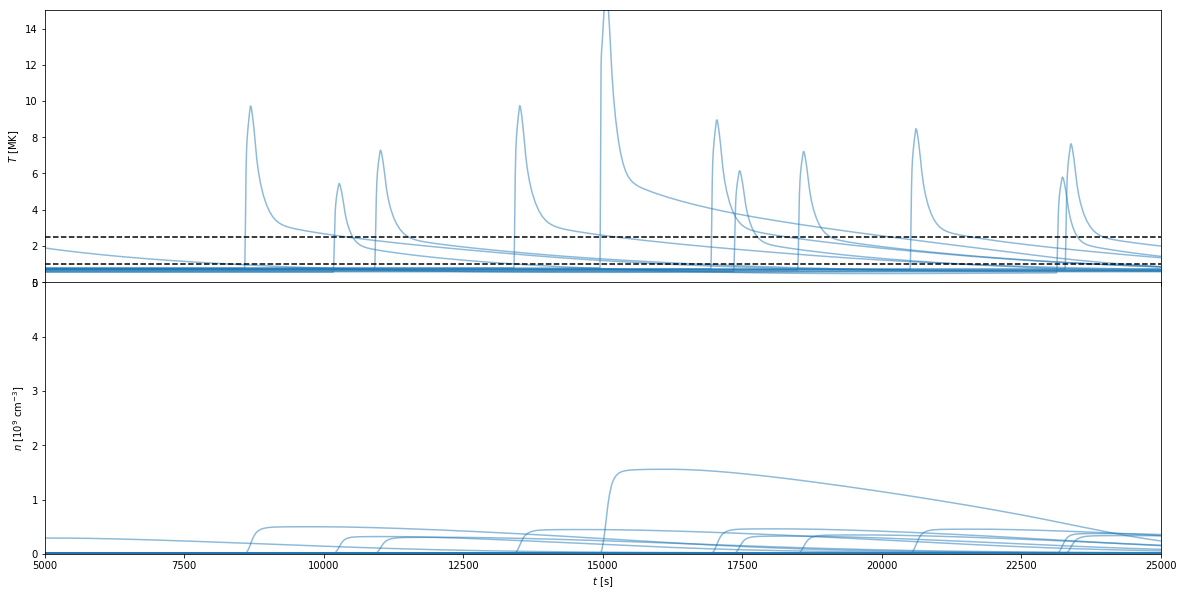

In [399]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for l in loops_p[:]:
    loop = lf_field.loops[base_field.loops.index(l)]
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.5)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.5)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.5)
axes[0].axhline(y=1,ls='--',color='k')
axes[0].axhline(y=2.5,ls='--',color='k')
axes[0].set_xlim(5e3,25e3)
axes[0].set_ylim(0,15)
axes[1].set_ylim(0,5)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

## Slice Through "Volume"

Now, instantiate the field for each heating model so that we have acccess to the coordinate for the loops. We will select those coordinates whose $\theta_x,\theta_y$ coordinates fall in each of the boxes and then select those rows from the interpolated temperatures and densities.

In [284]:
aia_hf = InstrumentSDOAIA([0,30000]*u.s,observer_coordinate=base_field.magnetogram.observer_coordinate)
aia_hf.counts_file = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA_counts.h5'

In [285]:
index_ic_x, = np.where(np.logical_and(aia_hf.total_coordinates.Tx >= left_ic.Tx, aia_hf.total_coordinates.Tx <= right_ic.Tx))
index_ic_y, = np.where(np.logical_and(aia_hf.total_coordinates.Ty >= left_ic.Ty, aia_hf.total_coordinates.Ty <= right_ic.Ty))
index_ic = np.intersect1d(index_ic_x,index_ic_y, assume_unique=True)
index_oc_x, = np.where(np.logical_and(aia_hf.total_coordinates.Tx >= left_oc.Tx, aia_hf.total_coordinates.Tx <= right_oc.Tx))
index_oc_y, = np.where(np.logical_and(aia_hf.total_coordinates.Ty >= left_oc.Ty, aia_hf.total_coordinates.Ty <= right_oc.Ty))
index_oc = np.intersect1d(index_oc_x,index_oc_y, assume_unique=True)
index_p_x, = np.where(np.logical_and(aia_hf.total_coordinates.Tx >= left_p.Tx, aia_hf.total_coordinates.Tx <= right_p.Tx))
index_p_y, = np.where(np.logical_and(aia_hf.total_coordinates.Ty >= left_p.Ty, aia_hf.total_coordinates.Ty <= right_p.Ty))
index_p = np.intersect1d(index_p_x,index_p_y, assume_unique=True)

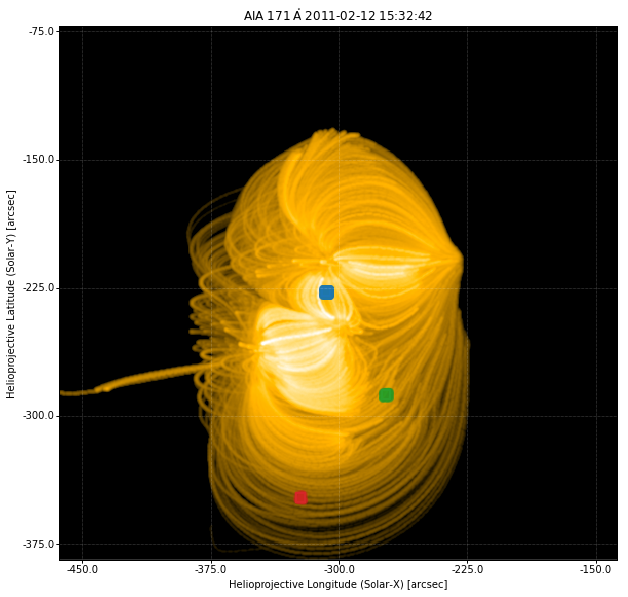

In [286]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=m)
m.plot(axes=ax,
       #norm=ImageNormalize(vmin=0,vmax=1e3,stretch=SqrtStretch())
       norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e-3,vmax=1e3)
      )
# Inner Core
width,height = 5*u.arcsec,5*u.arcsec
left_ic = SkyCoord(Tx=-310*u.arcsec,Ty=-230*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_ic = SkyCoord(Tx=left_ic.Tx+width,Ty=left_ic.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_ic, width, height, axes=ax, lw=2, color='C0')
ax.plot_coord(aia_hf.total_coordinates[index_ic].transform_to(m.coordinate_frame),ls='',marker='o',color='C0',alpha=0.1)
# Outer Core
left_oc = SkyCoord(Tx=-275*u.arcsec,Ty=-290*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_oc = SkyCoord(Tx=left_oc.Tx+width,Ty=left_oc.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_oc, width, height, axes=ax, lw=2, color='C2')
ax.plot_coord(aia_hf.total_coordinates[index_oc].transform_to(m.coordinate_frame),ls='',marker='o',color='C2',alpha=0.1)
# Periphery
left_p = SkyCoord(Tx=-325*u.arcsec,Ty=-350*u.arcsec,frame=base_field.magnetogram.coordinate_frame)
right_p = SkyCoord(Tx=left_p.Tx+width,Ty=left_p.Ty+height,frame=base_field.magnetogram.coordinate_frame)
m.draw_rectangle(left_p, width, height, axes=ax, lw=2, color='C3')
ax.plot_coord(aia_hf.total_coordinates[index_p].transform_to(m.coordinate_frame),ls='',marker='o',color='C3',alpha=0.1)

In [287]:
with h5py.File(aia_hf.counts_file, 'r') as hf:
    T_unbinned_hf_ic = np.array(hf['electron_temperature'][:,index_ic])
    n_unbinned_hf_ic = np.array(hf['ion_temperature'][:,index_ic])
    T_unbinned_hf_oc = np.array(hf['electron_temperature'][:,index_oc])
    n_unbinned_hf_oc = np.array(hf['ion_temperature'][:,index_oc])
    T_unbinned_hf_p = np.array(hf['electron_temperature'][:,index_p])
    n_unbinned_hf_p = np.array(hf['ion_temperature'][:,index_p])

In [288]:
bins,bin_range = aia_hf.make_detector_array(base_field)
num_bins_z = int(bins.z.value)/5
bin_range_z = (bin_range.z[0].value,bin_range.z[1].value)#(aia_hf.total_coordinates[index_ic].distance.value.min(), aia_hf.total_coordinates[index_ic].distance.value.max())

In [289]:
# inner core
z_mesh, t_mesh = np.meshgrid(aia_hf.total_coordinates[index_ic].distance.value,
                             aia_hf.observing_time.value)
z_coords_ic = z_mesh.flatten()
t_coords_ic = t_mesh.flatten()
# outer core
z_mesh, t_mesh = np.meshgrid(aia_hf.total_coordinates[index_oc].distance.value,
                             aia_hf.observing_time.value)
z_coords_oc = z_mesh.flatten()
t_coords_oc = t_mesh.flatten()
# periphery
z_mesh, t_mesh = np.meshgrid(aia_hf.total_coordinates[index_p].distance.value,
                             aia_hf.observing_time.value)
z_coords_p = z_mesh.flatten()
t_coords_p = t_mesh.flatten()

In [290]:
T_unbinned_hf_ic_flat = T_unbinned_hf_ic.flatten()
n_unbinned_hf_ic_flat = n_unbinned_hf_ic.flatten()
T_unbinned_hf_oc_flat = T_unbinned_hf_oc.flatten()
n_unbinned_hf_oc_flat = n_unbinned_hf_oc.flatten()
T_unbinned_hf_p_flat = T_unbinned_hf_p.flatten()
n_unbinned_hf_p_flat = n_unbinned_hf_p.flatten()

In [291]:
### Inner Core ###
# Normalization
norm_los_slice_hf_ic,z_edges,t_edges = np.histogram2d(z_coords_ic, t_coords_ic, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                                      range=(bin_range_z, np.array([0,3e4])),)
# Temperature
T_los_slice_hf_ic,_,_ = np.histogram2d(z_coords_ic,t_coords_ic, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                       range=(bin_range_z, np.array([0,3e4])), weights=T_unbinned_hf_ic_flat)
T_los_slice_hf_ic /= np.where(norm_los_slice_hf_ic == 0, 1, norm_los_slice_hf_ic)
# Density
n_los_slice_hf_ic, _, _ = np.histogram2d(z_coords_ic, t_coords_ic, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                         range=(bin_range_z, np.array([0,3e4])), weights=n_unbinned_hf_ic_flat)
z_mesh_ic,t_mesh_ic = np.meshgrid(t_edges[:-1], (z_edges[1:]+z_edges[:-1])/2)

In [292]:
### Outer Core ###
# Normalization
norm_los_slice_hf_oc,z_edges,t_edges = np.histogram2d(z_coords_oc, t_coords_oc, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                                      range=(bin_range_z, np.array([0,3e4])),)
# Temperature
T_los_slice_hf_oc,_,_ = np.histogram2d(z_coords_oc,t_coords_oc, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                       range=(bin_range_z, np.array([0,3e4])), weights=T_unbinned_hf_oc_flat)
T_los_slice_hf_oc /= np.where(norm_los_slice_hf_oc == 0, 1, norm_los_slice_hf_oc)
# Density
n_los_slice_hf_oc, _, _ = np.histogram2d(z_coords_oc, t_coords_oc, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                         range=(bin_range_z, np.array([0,3e4])), weights=n_unbinned_hf_oc_flat)
z_mesh_oc,t_mesh_oc = np.meshgrid(t_edges[:-1], (z_edges[1:]+z_edges[:-1])/2)

In [293]:
### Periphery ###
# Normalization
norm_los_slice_hf_p,z_edges,t_edges = np.histogram2d(z_coords_p, t_coords_p, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                                      range=(bin_range_z, np.array([0,3e4])),)
# Temperature
T_los_slice_hf_p,_,_ = np.histogram2d(z_coords_p,t_coords_p, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                       range=(bin_range_z, np.array([0,3e4])), weights=T_unbinned_hf_p_flat)
T_los_slice_hf_p /= np.where(norm_los_slice_hf_p == 0, 1, norm_los_slice_hf_p)
# Density
n_los_slice_hf_p, _, _ = np.histogram2d(z_coords_p, t_coords_p, bins=(num_bins_z, aia_hf.observing_time.shape[0]),
                                         range=(bin_range_z, np.array([0,3e4])), weights=n_unbinned_hf_p_flat)
z_mesh_p,t_mesh_p = np.meshgrid(t_edges[:-1], (z_edges[1:]+z_edges[:-1])/2)

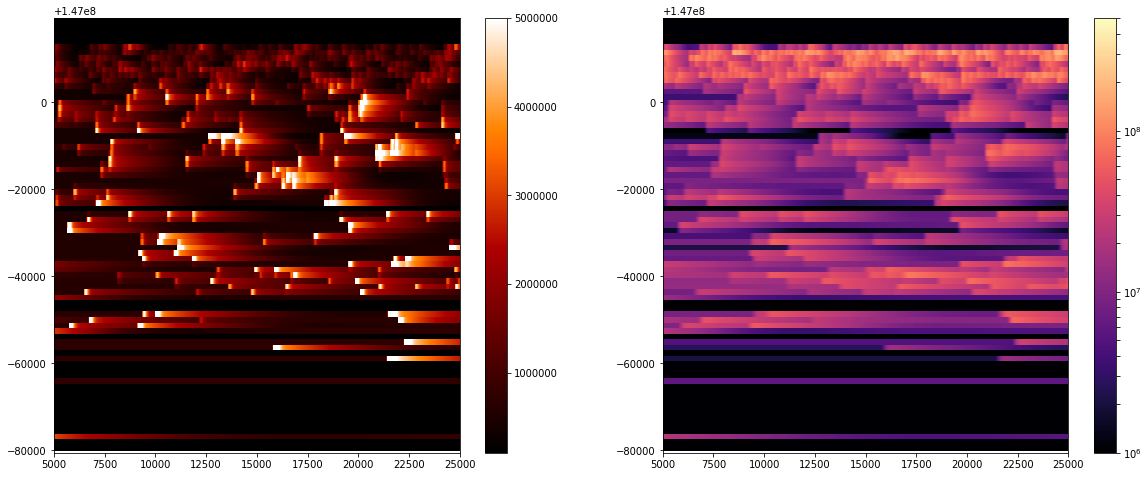

In [294]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
im = ax.pcolormesh(z_mesh_ic,t_mesh_ic,T_los_slice_hf_ic,
              vmin=1e5,vmax=5e6,
              cmap='hinodexrt')
ax.set_ylim(bin_range_z[0],bin_range_z[0]+(100*u.Mm).to(u.km).value)
ax.set_xlim(5e3,2.5e4)
fig.colorbar(im,ax=ax)
ax = fig.add_subplot(122)
im = ax.pcolormesh(z_mesh_ic,t_mesh_ic,n_los_slice_hf_ic,
                   norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e6,vmax=5e8),
                   cmap='magma')
ax.set_ylim(bin_range_z[0],bin_range_z[0]+(100*u.Mm).to(u.km).value)
ax.set_xlim(5e3,2.5e4)
fig.colorbar(im,ax=ax)

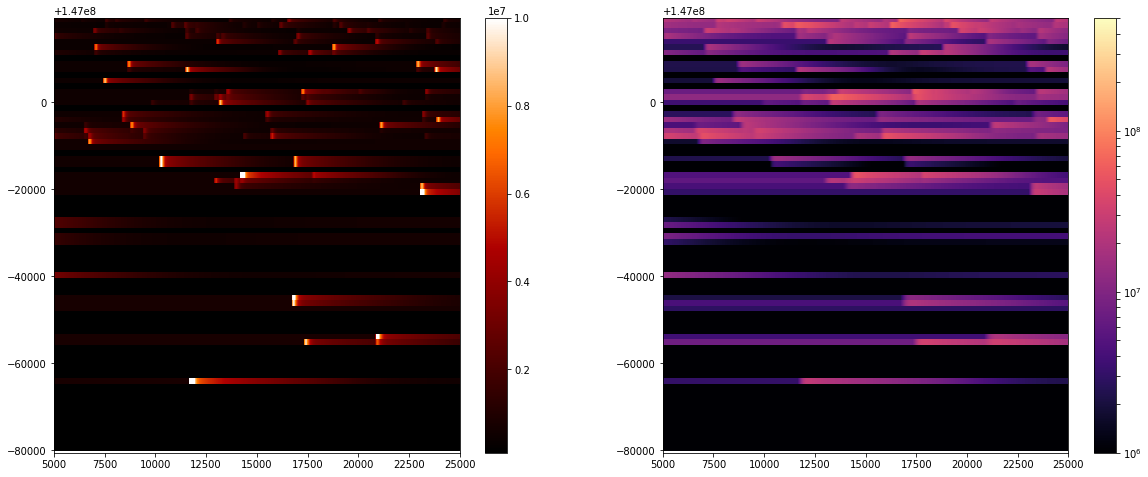

In [298]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
im = ax.pcolormesh(z_mesh_oc,t_mesh_oc,T_los_slice_hf_oc,
              vmin=1e5,vmax=1e7,
              cmap='hinodexrt')
ax.set_ylim(bin_range_z[0],bin_range_z[0]+(100*u.Mm).to(u.km).value)
ax.set_xlim(5e3,2.5e4)
fig.colorbar(im,ax=ax)
ax = fig.add_subplot(122)
im = ax.pcolormesh(z_mesh_oc,t_mesh_oc,n_los_slice_hf_oc,
                   norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e6,vmax=5e8),
                   cmap='magma')
ax.set_ylim(bin_range_z[0],bin_range_z[0]+(100*u.Mm).to(u.km).value)
ax.set_xlim(5e3,2.5e4)
fig.colorbar(im,ax=ax)

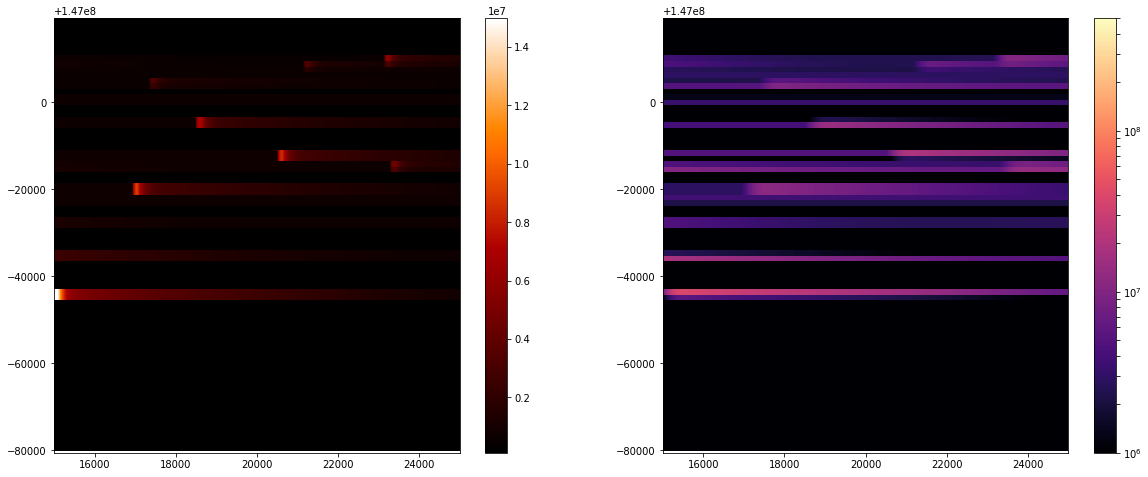

In [302]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
im = ax.pcolormesh(z_mesh_p,t_mesh_p,T_los_slice_hf_p,
              vmin=1e5,vmax=1.5e7,
              cmap='hinodexrt')
ax.set_ylim(bin_range_z[0],bin_range_z[0]+(100*u.Mm).to(u.km).value)
ax.set_xlim(1.5e4,2.5e4)
fig.colorbar(im,ax=ax)
ax = fig.add_subplot(122)
im = ax.pcolormesh(z_mesh_p,t_mesh_p,n_los_slice_hf_p,
                   norm=matplotlib.colors.SymLogNorm(1e-10,vmin=1e6,vmax=5e8),
                   cmap='magma')
ax.set_ylim(bin_range_z[0],bin_range_z[0]+(100*u.Mm).to(u.km).value)
ax.set_xlim(1.5e4,2.5e4)
fig.colorbar(im,ax=ax)